### Import packages and helper functions

In [1]:
import random
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import datasets, transforms

In [ ]:
from helper import split_and_transform, evaluate, train, predict

In [2]:
seed = 42
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

### Load the dataset

In [3]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

eval_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

dataset = datasets.ImageFolder(root="./dataset")

train_data, val_data, test_data = split_and_transform(dataset, train_transform, eval_transform)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.92156863..0.9764706].


Label: 0, Image shape: torch.Size([3, 128, 128])


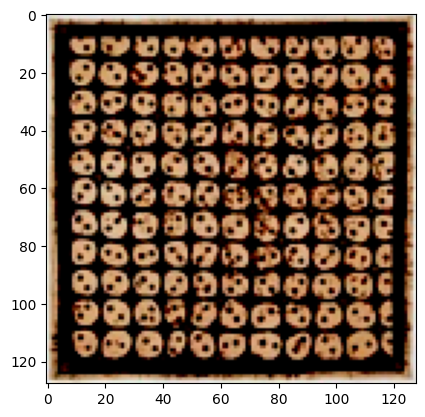

In [4]:
image, label = dataset[0]
plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
print(f"Label: {label}, Image shape: {image.shape}")

In [5]:
print(dataset.classes)

['kawung', 'mega_mendung', 'parang', 'truntum']


### Define the CNN model

In [6]:
class CNNModel(nn.Module):
    def __init__(self, num_classes):
        super(CNNModel, self).__init__()
        
        # Convolutional layers with batch normalization
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )

        # Pooling layer
        self.adaptive_pool = nn.AdaptiveAvgPool2d((4, 4))

        # Fully connected layers
        self.fc1 = nn.Linear(256 * 4 * 4, 1024)
        self.fc2 = nn.Linear(1024, num_classes)

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.6)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)

        x = self.adaptive_pool(x)
        x = x.view(x.size(0), -1)

        x = nn.ReLU()(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return x

### Train, validate, and test the model

In [10]:
num_classes = len(dataset.classes)
model = CNNModel(num_classes)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-3)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train(model, train_data, val_data, criterion, optimizer, device, early_stopping=True)

Epoch 1/1000, Loss: 2.2726, Validation Accuracy: 46.8254
Epoch 2/1000, Loss: 1.1494, Validation Accuracy: 54.7619
Epoch 3/1000, Loss: 0.9672, Validation Accuracy: 55.5556
Epoch 4/1000, Loss: 0.9106, Validation Accuracy: 64.2857
Epoch 5/1000, Loss: 0.8546, Validation Accuracy: 66.6667
Epoch 6/1000, Loss: 0.8287, Validation Accuracy: 65.8730
Epoch 7/1000, Loss: 0.8377, Validation Accuracy: 57.9365
Epoch 8/1000, Loss: 0.7879, Validation Accuracy: 66.6667
Epoch 9/1000, Loss: 0.6908, Validation Accuracy: 66.6667
Epoch 10/1000, Loss: 0.6335, Validation Accuracy: 72.2222
Epoch 11/1000, Loss: 0.6931, Validation Accuracy: 74.6032
Epoch 12/1000, Loss: 0.6068, Validation Accuracy: 76.1905
Epoch 13/1000, Loss: 0.5854, Validation Accuracy: 76.1905
Epoch 14/1000, Loss: 0.5310, Validation Accuracy: 75.3968
Epoch 15/1000, Loss: 0.4795, Validation Accuracy: 73.0159
Epoch 16/1000, Loss: 0.5495, Validation Accuracy: 68.2540
Epoch 17/1000, Loss: 0.4839, Validation Accuracy: 75.3968
Epoch 18/1000, Loss: 0.

In [11]:
accuracy = evaluate(model, test_data, device)
print(f"Test Accuracy: {accuracy:.4f}")

Test Accuracy: 85.0394


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


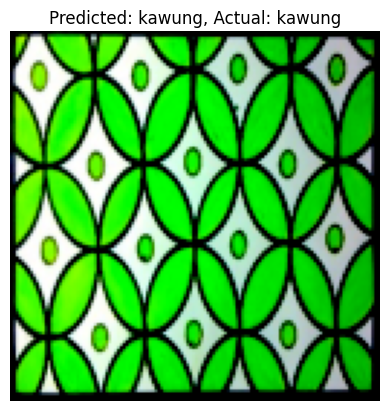

In [12]:
data_iter = iter(test_data)
images, labels = next(data_iter)
random_id = random.randint(0, len(images) - 1)
image = images[random_id].unsqueeze(0).to(device)
label = labels[random_id].item()

predicted = predict(model, image)
predicted_label = dataset.classes[predicted.item()]

plt.imshow(image.squeeze().cpu().permute(1, 2, 0))
plt.title(f"Predicted: {predicted_label}, Actual: {dataset.classes[label]}")
plt.axis("off")
plt.show()

In [13]:
torch.save(model.state_dict(), 'batik_classification_model.pth')